Este notebook esta basado en el [paper](http://web.archive.org/web/20060720040135/http://members.fortunecity.com/jpeschel/gillog1.htm) utilizado para crackear en el M4 Project.

In [1]:
from enigma.enigma import Enigma
from enigma.rotors.rotor_with_mapping_and_notches import RotorWithMappingAndNotches
from enigma.rotors.rotor_I import RotorI
from enigma.rotors.rotor_II import RotorII
from enigma.rotors.rotor_III import RotorIII
from enigma.rotors.rotor_IV import RotorIV
from enigma.rotors.rotor_V import RotorV
from enigma.reflectors.reflector_b import ReflectorB
from enigma.plugboard import Plugboard
from language_models.character_frequency_kld_language_model import CharacterFrequencyKLDLanguageModel
from language_models.character_frequency_ic_language_model import CharacterFrequencyICLanguageModel
from language_models.markov_chain_model import MarkovChainModel

import random
from collections import OrderedDict
import heapq
from itertools import permutations, combinations
from tqdm import tqdm
from tqdm.auto import trange
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
import re
from Levenshtein import distance

# Orden de los rotores

Vamos a simular la selección de los rotores I, II, III, IV y V para la Enigma M3 como esta descripto en el paper. Vamos a utilizar siempre el reflector B.

In [2]:
POSSIBLE_ROTORS = {RotorI, RotorII, RotorIII, RotorIV, RotorV}
POSSIBLE_LETTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def config_to_string(rotors_classes, offsets, ringstellungs, plugboard_tuples):
    string = ""
    for rot, off, rs in zip(rotors_classes, offsets, ringstellungs):
        string += rot.__name__+"(o:%d,rs:%d)"%(off,rs)+"|"
    for l1, l2 in plugboard_tuples:
        string += l1+l2
    return string

def get_random_plugboad(plugboard_size: int):
    letter_sample = random.sample(list(POSSIBLE_LETTERS), plugboard_size*2)
    plugboard_tuples = []
    for i in range(len(letter_sample)//2):
        plugboard_tuples.append((letter_sample[i*2], letter_sample[(i*2)+1]))
    plugboard_tuples = sorted(plugboard_tuples, key=lambda x: x[0])
    return plugboard_tuples

def get_random_config(plugboard_size: int):
    rotors_to_use = random.sample(POSSIBLE_ROTORS, 3)
    offsets = [random.randint(0,25) for _ in range(3)]
    ringstellungs = [random.randint(0,25) for _ in range(3)]
    plugboard_tuples = get_random_plugboad(plugboard_size)
    return rotors_to_use, offsets, ringstellungs, plugboard_tuples

def transform_to_valid_chars(text: str):
    text = text.upper()
    return "".join([c for c in text if c in POSSIBLE_LETTERS])

def string_to_config(string: str):
    match = re.findall("(.+)\(o:(\d+),rs:(\d+)\)\|(.+)\(o:(\d+),rs:(\d+)\)\|(.+)\(o:(\d+),rs:(\d+)\)\|(.*)", 
                       string, re.IGNORECASE)[0]
    available_rotors = {rot.__name__:rot for rot in RotorWithMappingAndNotches.__subclasses__()}
    rotors_classes = [available_rotors[match[0]], available_rotors[match[3]], available_rotors[match[6]]]
    offsets = [int(match[1]), int(match[4]), int(match[7])]
    ringstellungs = [int(match[2]), int(match[5]), int(match[8])]
    plugboard_tuples = []
    for i in range(len(match[9])//2):
        plugboard_tuples.append((match[9][i*2],match[9][(i*2)+1]))
    return rotors_classes, offsets, ringstellungs, plugboard_tuples
        

In [3]:
config_to_string(*get_random_config(10))

'RotorII(o:21,rs:3)|RotorI(o:1,rs:2)|RotorIII(o:9,rs:19)|EUFPGAHJNDQOSIXCYMZT'

In [4]:
string_to_config(config_to_string(*get_random_config(10)))

([enigma.rotors.rotor_II.RotorII,
  enigma.rotors.rotor_IV.RotorIV,
  enigma.rotors.rotor_III.RotorIII],
 [7, 25, 6],
 [7, 6, 24],
 [('C', 'F'),
  ('D', 'N'),
  ('H', 'R'),
  ('K', 'Z'),
  ('L', 'S'),
  ('O', 'J'),
  ('V', 'I'),
  ('W', 'M'),
  ('X', 'Q'),
  ('Y', 'U')])

In [5]:
with open('books/Alices_Adventures_in_Wonderland.txt', 'r') as book:
    book_train = transform_to_valid_chars(book.read())
with open('books/Pride_and_Prejudice.txt', 'r') as book:
    book_test = transform_to_valid_chars(book.read())

In [6]:
kld_char_freq = CharacterFrequencyKLDLanguageModel(book_train)
ic_char_freq = CharacterFrequencyICLanguageModel(book_train)
markov_chain1 = MarkovChainModel(book_train)

In [7]:
TEST_TEXT_LENGHT = 1000
DEFAULT_PLUGBOARD_SIZE = 1

rotors, offsets, ringstellungs, plugboard_tuples =get_random_config(DEFAULT_PLUGBOARD_SIZE)
random_config_key = config_to_string(rotors,offsets,ringstellungs,plugboard_tuples)
random_test_pos = random.randint(0,len(book_test)- TEST_TEXT_LENGHT)
random_text_test = book_test[random_test_pos:random_test_pos+TEST_TEXT_LENGHT]
rotors_to_use = [rot_c(offset=off, ring_setting=rs) 
                 for rot_c, off, rs in zip(rotors, offsets, ringstellungs)]
random_engima = Enigma(reflector=ReflectorB(),
                      plugboard=Plugboard(plugboard_tuples), rotors=rotors_to_use)
cyphertext = random_engima.encrypt(random_text_test)
random_config_key

'RotorI(o:17,rs:2)|RotorV(o:8,rs:12)|RotorII(o:18,rs:24)|CG'

In [8]:
kld_char_freq.fitness(random_text_test), ic_char_freq.fitness(random_text_test), markov_chain1.fitness(random_text_test)

(-0.05097182192800292, -0.06101980926779671, -56.609340744978084)

### Explorar todos los rotores

In [9]:
scores = {}

def compute_scores(rot1, rot2, rot3, offsets):
    off1 = offsets % 26
    off2 = (offsets//26) % 26
    off3 = (offsets//(26**2)) % 26
    enigma = Enigma(reflector=ReflectorB(),
                      plugboard=Plugboard(), 
                        rotors=[rot1(offset=off1), rot2(offset=off2), rot3(offset=off3)])
    decrypted = enigma.decrypt(cyphertext)
    config = config_to_string([rot1, rot2, rot3], [off1,off2,off3], [0,0,0], [])
    return config, {'KLD': kld_char_freq.fitness(decrypted), 'IC': ic_char_freq.fitness(decrypted), 'Markov': markov_chain1.fitness(decrypted)}

for rot1, rot2, rot3 in permutations(POSSIBLE_ROTORS, 3):
    with Pool(5) as p:
        partial_compute = partial(compute_scores, rot1, rot2, rot3)
        r = list(tqdm(p.imap(partial_compute, range(26**3)), total=26**3))
    for c, s in r:
        scores[c] = s

100%|██████████| 17576/17576 [00:41<00:00, 425.03it/s]


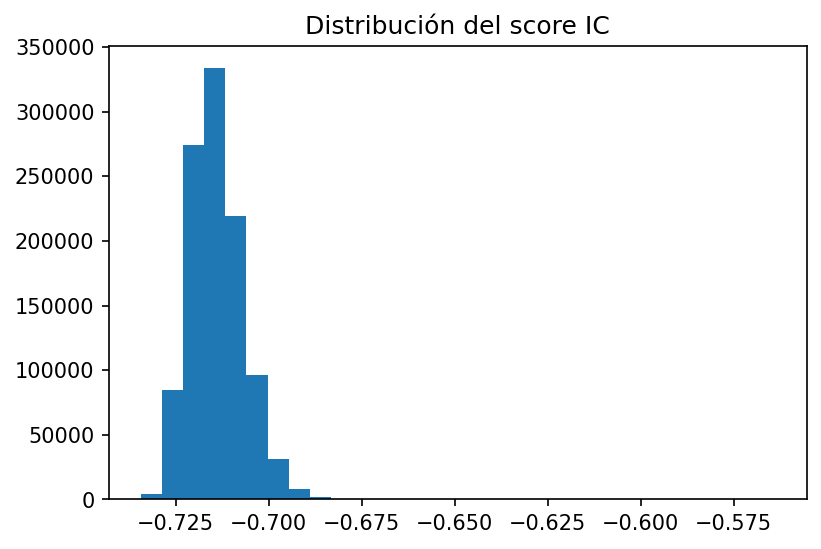

In [10]:
plt.figure(dpi=150)
plt.title("Distribución del score IC")
plt.hist([s['IC'] for s in scores.values()], bins=30)
plt.show()

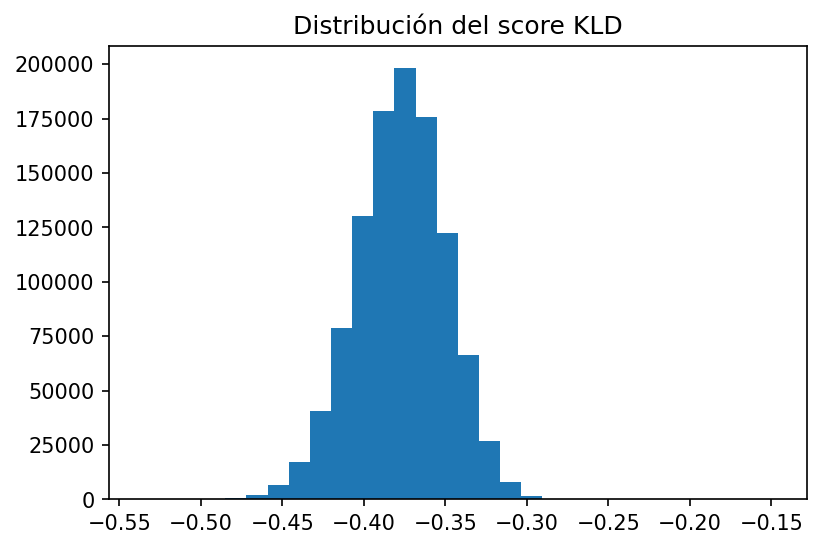

In [11]:
plt.figure(dpi=150)
plt.title("Distribución del score KLD")
plt.hist([s['KLD'] for s in scores.values()], bins=30)
plt.show()

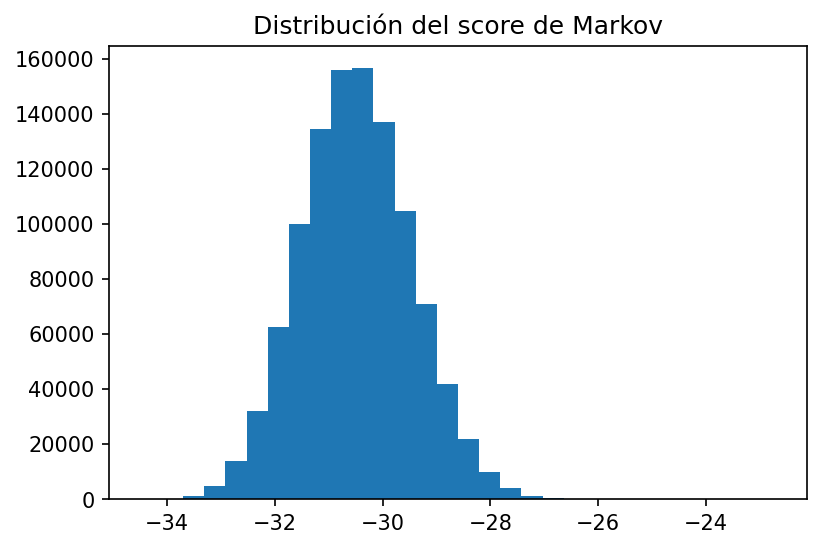

In [12]:
plt.figure(dpi=150)
plt.title("Distribución del score de Markov")
plt.hist([s['Markov'] for s in scores.values()], bins=30)
plt.show()

In [13]:
top_ic = sorted([(c,s['IC']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)
top_ic[:10]

[('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|',
  -0.5638946841426715),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:0)|',
  -0.6575363257843132),
 ('RotorV(o:21,rs:0)|RotorIII(o:15,rs:0)|RotorIV(o:15,rs:0)|',
  -0.66430309255108),
 ('RotorIII(o:17,rs:0)|RotorIV(o:1,rs:0)|RotorI(o:14,rs:0)|',
  -0.6658126020605895),
 ('RotorV(o:17,rs:0)|RotorIV(o:5,rs:0)|RotorI(o:16,rs:0)|',
  -0.6670097992577866),
 ('RotorI(o:13,rs:0)|RotorII(o:0,rs:0)|RotorIV(o:21,rs:0)|',
  -0.6683111005590878),
 ('RotorIV(o:3,rs:0)|RotorIII(o:11,rs:0)|RotorV(o:11,rs:0)|',
  -0.6684672567152441),
 ('RotorI(o:6,rs:0)|RotorII(o:2,rs:0)|RotorIV(o:12,rs:0)|',
  -0.6688316210796084),
 ('RotorI(o:4,rs:0)|RotorIII(o:25,rs:0)|RotorV(o:5,rs:0)|',
  -0.6693521416001289),
 ('RotorIII(o:18,rs:0)|RotorI(o:12,rs:0)|RotorIV(o:23,rs:0)|',
  -0.6693521416001289)]

In [14]:
top_kld = sorted([(c,s['KLD']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)
top_kld[:10]

[('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|',
  -0.14782910998618512),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:0)|',
  -0.2131152355487701),
 ('RotorIV(o:7,rs:0)|RotorII(o:13,rs:0)|RotorV(o:2,rs:0)|',
  -0.25936495613819566),
 ('RotorIII(o:8,rs:0)|RotorIV(o:0,rs:0)|RotorI(o:9,rs:0)|',
  -0.26072682946220926),
 ('RotorV(o:21,rs:0)|RotorIV(o:21,rs:0)|RotorI(o:16,rs:0)|',
  -0.26372486664163464),
 ('RotorII(o:0,rs:0)|RotorIV(o:25,rs:0)|RotorI(o:11,rs:0)|',
  -0.26828692711003443),
 ('RotorV(o:13,rs:0)|RotorIII(o:5,rs:0)|RotorIV(o:20,rs:0)|',
  -0.26861152023683166),
 ('RotorI(o:17,rs:0)|RotorIV(o:13,rs:0)|RotorV(o:5,rs:0)|',
  -0.2695340276227604),
 ('RotorI(o:2,rs:0)|RotorV(o:9,rs:0)|RotorII(o:14,rs:0)|',
  -0.26954673247556316),
 ('RotorIV(o:8,rs:0)|RotorI(o:5,rs:0)|RotorIII(o:10,rs:0)|',
  -0.27022756000587156)]

In [15]:
top_markov = sorted([(c,s['Markov']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)
top_markov[:10]

[('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|',
  -22.718963146546034),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:0)|',
  -24.128936435110724),
 ('RotorIV(o:16,rs:0)|RotorV(o:6,rs:0)|RotorI(o:11,rs:0)|',
  -25.53146747362302),
 ('RotorII(o:7,rs:0)|RotorIII(o:2,rs:0)|RotorIV(o:23,rs:0)|',
  -25.68124343745296),
 ('RotorI(o:25,rs:0)|RotorII(o:7,rs:0)|RotorIV(o:25,rs:0)|',
  -25.69015466698458),
 ('RotorIV(o:12,rs:0)|RotorV(o:23,rs:0)|RotorIII(o:21,rs:0)|',
  -25.76664889899842),
 ('RotorIII(o:16,rs:0)|RotorII(o:5,rs:0)|RotorV(o:23,rs:0)|',
  -25.79349315331161),
 ('RotorV(o:25,rs:0)|RotorIV(o:25,rs:0)|RotorI(o:8,rs:0)|',
  -25.822249166017105),
 ('RotorIII(o:16,rs:0)|RotorIV(o:1,rs:0)|RotorII(o:14,rs:0)|',
  -25.82691923184708),
 ('RotorIII(o:21,rs:0)|RotorIV(o:11,rs:0)|RotorI(o:7,rs:0)|',
  -25.876995933632948)]

# Ringstellung

In [16]:
TOP_TO_CHOICE = 6

best_choices = ([t[0] for t in top_ic[:TOP_TO_CHOICE]]+
                [t[0] for t in top_kld[:TOP_TO_CHOICE]]+
                [t[0] for t in top_markov[:TOP_TO_CHOICE]])

# (rotors_classes, offsets, ringstellungs, plugboard_tuples)
best_choices = [string_to_config(c) for c in best_choices]

def compute_rs_score(rot1, rot2, rot3, offsets, ringstellungs):
    off1, off2, off3 = offsets
    rs1 = ringstellungs % 26
    rs2 = (ringstellungs//26) % 26
    rs3 = (ringstellungs//(26**2)) % 26
    enigma = Enigma(reflector=ReflectorB(),
                      plugboard=Plugboard(), 
                        rotors=[rot1(offset=off1,ring_setting=rs1), 
                                rot2(offset=off2,ring_setting=rs2), 
                                rot3(offset=off3,ring_setting=rs3)])
    decrypted = enigma.decrypt(cyphertext)
    config = config_to_string([rot1, rot2, rot3], [off1,off2,off3], [rs1,rs2,rs3], [])
    return config, {'KLD': kld_char_freq.fitness(decrypted), 'IC': ic_char_freq.fitness(decrypted), 'Markov': markov_chain1.fitness(decrypted)}

ringstellung_scores = {}

for choice in best_choices:
    rot1, rot2, rot3 = choice[0]
    with Pool(5) as p:
        partial_compute = partial(compute_rs_score, rot1, rot2, rot3, choice[1])
        r = list(tqdm(p.imap(partial_compute, range(26**3)), total=26**3))
    for c, s in r:
        ringstellung_scores[c] = s

100%|██████████| 17576/17576 [00:40<00:00, 431.38it/s]


In [17]:
top_ic_rs = sorted([(c,s['IC']) for c,s in ringstellung_scores.items()], key=lambda x: x[1], reverse=True)
top_ic_rs[:10]

[('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|',
  -0.5638946841426715),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:1)|',
  -0.5638946841426715),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:25)|',
  -0.6575363257843132),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:0)|',
  -0.6575363257843132),
 ('RotorV(o:21,rs:0)|RotorIII(o:15,rs:0)|RotorIV(o:15,rs:0)|',
  -0.66430309255108),
 ('RotorIII(o:17,rs:0)|RotorIV(o:1,rs:0)|RotorI(o:14,rs:0)|',
  -0.6658126020605895),
 ('RotorV(o:17,rs:0)|RotorIV(o:5,rs:0)|RotorI(o:16,rs:0)|',
  -0.6670097992577866),
 ('RotorIII(o:8,rs:12)|RotorIV(o:0,rs:20)|RotorI(o:9,rs:6)|',
  -0.6681028923508798),
 ('RotorI(o:13,rs:0)|RotorII(o:0,rs:0)|RotorIV(o:21,rs:0)|',
  -0.6683111005590878),
 ('RotorIV(o:12,rs:3)|RotorV(o:23,rs:1)|RotorIII(o:21,rs:11)|',
  -0.6698726621206494)]

In [18]:
top_kld_rs = sorted([(c,s['KLD']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)
top_kld_rs[:10]

[('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|',
  -0.14782910998618512),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:0)|',
  -0.2131152355487701),
 ('RotorIV(o:7,rs:0)|RotorII(o:13,rs:0)|RotorV(o:2,rs:0)|',
  -0.25936495613819566),
 ('RotorIII(o:8,rs:0)|RotorIV(o:0,rs:0)|RotorI(o:9,rs:0)|',
  -0.26072682946220926),
 ('RotorV(o:21,rs:0)|RotorIV(o:21,rs:0)|RotorI(o:16,rs:0)|',
  -0.26372486664163464),
 ('RotorII(o:0,rs:0)|RotorIV(o:25,rs:0)|RotorI(o:11,rs:0)|',
  -0.26828692711003443),
 ('RotorV(o:13,rs:0)|RotorIII(o:5,rs:0)|RotorIV(o:20,rs:0)|',
  -0.26861152023683166),
 ('RotorI(o:17,rs:0)|RotorIV(o:13,rs:0)|RotorV(o:5,rs:0)|',
  -0.2695340276227604),
 ('RotorI(o:2,rs:0)|RotorV(o:9,rs:0)|RotorII(o:14,rs:0)|',
  -0.26954673247556316),
 ('RotorIV(o:8,rs:0)|RotorI(o:5,rs:0)|RotorIII(o:10,rs:0)|',
  -0.27022756000587156)]

In [19]:
top_markov_rs = sorted([(c,s['Markov']) for c,s in scores.items()], key=lambda x: x[1], reverse=True)
top_markov_rs[:10]

[('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|',
  -22.718963146546034),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:0)|',
  -24.128936435110724),
 ('RotorIV(o:16,rs:0)|RotorV(o:6,rs:0)|RotorI(o:11,rs:0)|',
  -25.53146747362302),
 ('RotorII(o:7,rs:0)|RotorIII(o:2,rs:0)|RotorIV(o:23,rs:0)|',
  -25.68124343745296),
 ('RotorI(o:25,rs:0)|RotorII(o:7,rs:0)|RotorIV(o:25,rs:0)|',
  -25.69015466698458),
 ('RotorIV(o:12,rs:0)|RotorV(o:23,rs:0)|RotorIII(o:21,rs:0)|',
  -25.76664889899842),
 ('RotorIII(o:16,rs:0)|RotorII(o:5,rs:0)|RotorV(o:23,rs:0)|',
  -25.79349315331161),
 ('RotorV(o:25,rs:0)|RotorIV(o:25,rs:0)|RotorI(o:8,rs:0)|',
  -25.822249166017105),
 ('RotorIII(o:16,rs:0)|RotorIV(o:1,rs:0)|RotorII(o:14,rs:0)|',
  -25.82691923184708),
 ('RotorIII(o:21,rs:0)|RotorIV(o:11,rs:0)|RotorI(o:7,rs:0)|',
  -25.876995933632948)]

# Explore plugboard

In [23]:
TOP_TO_CHOICE = 3

best_choices = ([t[0] for t in top_ic_rs[:TOP_TO_CHOICE]]+
                [t[0] for t in top_kld_rs[:TOP_TO_CHOICE]]+
                [t[0] for t in top_markov_rs[:TOP_TO_CHOICE]])

# (rotors_classes, offsets, ringstellungs, plugboard_tuples)
best_choices = [string_to_config(c) for c in best_choices]

def find_best_plugboards(lang_model, choice):
    rotors_classes, offsets, ringstellungs, _ = choice
    rot1, rot2, rot3 = rotors_classes
    off1, off2, off3 = offsets
    rs1, rs2, rs3 = ringstellungs
    actual_pb = []
    for _ in range(DEFAULT_PLUGBOARD_SIZE):
        actual_letters = POSSIBLE_LETTERS
        for l1, l2 in actual_pb:
            actual_letters = actual_letters.replace(l1,"").replace(l2,"")
        best_tuple = (('A','A'), -999999)
        
        for l1, l2 in combinations(list(actual_letters), 2):
            enigma = Enigma(reflector=ReflectorB(),
                              plugboard=Plugboard(actual_pb+[(l1,l2)]), 
                                rotors=[rot1(offset=off1,ring_setting=rs1), 
                                        rot2(offset=off2,ring_setting=rs2), 
                                        rot3(offset=off3,ring_setting=rs3)])
            decrypted = enigma.decrypt(cyphertext)
            score = lang_model.fitness(decrypted)
            if score > best_tuple[1]:
                best_tuple = ((l1, l2), score)
        actual_pb.append(best_tuple[0])
        
    return actual_pb

with Pool(5) as p:
    partial_finder = partial(find_best_plugboards, ic_char_freq)
    pbs_ic = list(tqdm(p.imap(partial_finder, best_choices), total=9))
with Pool(5) as p:
    partial_finder = partial(find_best_plugboards, kld_char_freq)
    pbs_kld = list(tqdm(p.imap(partial_finder, best_choices), total=9))
with Pool(5) as p:
    partial_finder = partial(find_best_plugboards, markov_chain1)
    pbs_markov = list(tqdm(p.imap(partial_finder, best_choices), total=9))

100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


In [24]:
final_scores = {}

for i in range(len(best_choices)):
    rotors_classes, offsets, ringstellungs, _ = best_choices[i]
    rot1, rot2, rot3 = rotors_classes
    off1, off2, off3 = offsets
    rs1, rs2, rs3 = ringstellungs
    for pb in [pbs_ic[i]]+[pbs_kld[i]]+[pbs_markov[i]]:
        enigma = Enigma(reflector=ReflectorB(),
                      plugboard=Plugboard(pb), 
                        rotors=[rot1(offset=off1,ring_setting=rs1), 
                                rot2(offset=off2,ring_setting=rs2), 
                                rot3(offset=off3,ring_setting=rs3)])
        decrypted = enigma.decrypt(cyphertext)
        config = config_to_string([rot1, rot2, rot3], [off1,off2,off3], [rs1,rs2,rs3], pb)
        final_scores[config] = ({'KLD': kld_char_freq.fitness(decrypted), 'IC': ic_char_freq.fitness(decrypted), 'Markov': markov_chain1.fitness(decrypted)}, decrypted)
    

In [31]:
[(k,distance(random_text_test, v[1])) for k,v in final_scores.items()]

[('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|CG', 427),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:0)|GQ', 514),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:1)|CG', 427),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:1)|GQ', 514),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:19,rs:25)|CG', 558),
 ('RotorI(o:15,rs:0)|RotorV(o:21,rs:0)|RotorII(o:20,rs:0)|CG', 558),
 ('RotorIV(o:7,rs:0)|RotorII(o:13,rs:0)|RotorV(o:2,rs:0)|JR', 888),
 ('RotorIV(o:7,rs:0)|RotorII(o:13,rs:0)|RotorV(o:2,rs:0)|WX', 881),
 ('RotorIV(o:7,rs:0)|RotorII(o:13,rs:0)|RotorV(o:2,rs:0)|QU', 881),
 ('RotorIV(o:16,rs:0)|RotorV(o:6,rs:0)|RotorI(o:11,rs:0)|ST', 884),
 ('RotorIV(o:16,rs:0)|RotorV(o:6,rs:0)|RotorI(o:11,rs:0)|LV', 879),
 ('RotorIV(o:16,rs:0)|RotorV(o:6,rs:0)|RotorI(o:11,rs:0)|BV', 880)]

In [34]:
sorted([(v[1],distance(random_text_test, v[1])) for v in final_scores.values()], key=lambda x: x[1])[0]

('SKLWVEYAZMZAYISJCUBCCOWSSISDRZIFCUAPIBDBSQPYLUIXDZRUDSNTMXAHKUPKBZULNCLDGWSHVKCJHLLUPHSGXCOGQXIYJFJHKNJLRFTHECOPYRIGHTHOLDERFOUNDKMTHEBEGINNINGOFTHISWORKEDLHOTUNLINKORDETACHORREMOVEWOEFULLPROJECTGUTENBERGTMLFRENSETERMSFROMTHISWORKORAXBFILESCONTAININGAPARTOFTHHZWORKORANYOTHERWORKASSOCIZSEDWITHPROJECTGUTENBERGTMGBONOTCOPYDISPLAYPERFORMDIPGRIBUTEORREDISTRIBUTETHISHMECTRONICWORKORANYPARTOFTFCSELECTRONICWORKWITHOUTPRMBINENTLYDISPLAYINGTHESENTKYCESETFORTHINPARAGRAPHEWIZJWRWKFVKQZGTFEAQPSVWJXNYTUOBASTGCDETAUKYGZOSBUASEBVJFHDYPIFPMFSEKSIBLYDAQHMSEZLNTTFQRZMEXQKRJOGRUMWDJTOBYGCSBBEQTQWOTOHTFMPHEGCAZJBKRMIRJXRGZZNGMFXFBQRSTUXLFDUKGJFGBCLQTPVZBBIWHOHBLDNGIXJYKZHLLEIFYOXCWSTUNIPDBSBRGVRGJLGENPOSOFAXKGLFMKNCWYAWTVCPHHSKPDZDYLWLHDTZJTAYBJEWSQJRHFRLBODCJMOSQBEDYDNUQMJGIKVHDRFLHRUKKDJBMCIIOROTHERFORMATUSEDINTHTEFFICIALVERSIONPOSTEDONTHZJFFICIALPROJECTGUTENBERGTNAEBSITEWWWGUTENBERGORGYOUAKSTATNOADDITIONALCOSTFEEOZHXPENSETOTHEUSERPROVIDEACVWYAMEANSOFEXPORTINGACOPYOABMEANSOFOBTAININGACOPYUPOUOEQUESTOFT

In [27]:
random_text_test

'PYRIGHTHOLDERADDITIONALTERMSWILLBELINKEDTOTHEPROJECTGUTENBERGTMLICENSEFORALLWORKSPOSTEDWITHTHEPERMISSIONOFTHECOPYRIGHTHOLDERFOUNDATTHEBEGINNINGOFTHISWORKEDONOTUNLINKORDETACHORREMOVETHEFULLPROJECTGUTENBERGTMLICENSETERMSFROMTHISWORKORANYFILESCONTAININGAPARTOFTHISWORKORANYOTHERWORKASSOCIATEDWITHPROJECTGUTENBERGTMEDONOTCOPYDISPLAYPERFORMDISTRIBUTEORREDISTRIBUTETHISELECTRONICWORKORANYPARTOFTHISELECTRONICWORKWITHOUTPROMINENTLYDISPLAYINGTHESENTENCESETFORTHINPARAGRAPHEWITHACTIVELINKSORIMMEDIATEACCESSTOTHEFULLTERMSOFTHEPROJECTGUTENBERGTMLICENSEEYOUMAYCONVERTTOANDDISTRIBUTETHISWORKINANYBINARYCOMPRESSEDMARKEDUPNONPROPRIETARYORPROPRIETARYFORMINCLUDINGANYWORDPROCESSINGORHYPERTEXTFORMHOWEVERIFYOUPROVIDEACCESSTOORDISTRIBUTECOPIESOFAPROJECTGUTENBERGTMWORKINAFORMATOTHERTHANPLAINVANILLAASCIIOROTHERFORMATUSEDINTHEOFFICIALVERSIONPOSTEDONTHEOFFICIALPROJECTGUTENBERGTMWEBSITEWWWGUTENBERGORGYOUMUSTATNOADDITIONALCOSTFEEOREXPENSETOTHEUSERPROVIDEACOPYAMEANSOFEXPORTINGACOPYORAMEANSOFOBTAININGACOPYUPONREQUESTOFTH